# Comparação dos processos de OneHotEncoder e LabelEncoder personalizado para variáveis Categóricas Ordinais

### Hipótese Proposta
Após a análise anterior, na qual pôde-se perceber uma melhora na precisão de algoritmos de machine learning utilizando um processo personalizado de labelencoder para as variáveis categóricas ordinais, agora, busca-se comparar qual a diferença de impacto na precisão entre o processo proposto e o processo de *OneHotEncoder*.

### Funcionamento do processo de OneHotEncoder
Ao se ter uma base de dados com variáveis categóricas, é preciso primeiramente convertê-los em valores numéricos **(LabelEncoder)**, dada as necessidades para o funcionamento dos algoritmos de machine learning. No entanto, os valores dessas variáveis que antes não possuíam uma relação entre si **(categóricas nominais)**, ou que possuíam uma relação de ordenação **(categóricas ordinais)** ao serem convertidas para valores numéricos, passam obrigatoriamente a apresentar uma relação estritamente numérica, por exemplo, valor 3 é maior que o valor 1 e que o valor 0, e o valor 1 está mais próximo do valor 0 do que do valor 3, enquanto que essa relação não existia antes ou que a relação até então existente não é preservada no processo.

Uma forma de superar esse problema é fazendo uso do processo de *onehotencoder*. O que esse processo faz é transformar cada valor de cada variável categórica selecionada em um novo atributo a ser preenchido com valor 1 ou 0 (lógica booleana). Caso aquele registro apresente aquele determinado valor, ele recebe o valor 1 nesse atributo e 0 nos demais atributos referente aquela variável categória a que fazia parte. Para esclarecer, considere o exemplo abaixo:

Uma base de dados possui o atributo **país** com os valores *brasil*, *eua* e *frança*. E possui os seguintes registros **{{brasil}, {frança}, {eua}, {frança}}**. Após o processeo de onehotencoder, a base de dados passaria a ter 3 atributos **brasil**, **eua** e **frança**, nessa ordem, e os registros passariam a ter os seguintes valores **{{1, 0, 0}, {0, 0, 1}, {0, 1, 0}, {0, 0 1}}**.

Dessa forma, aquela relação que seria criada pelo labelencoder, que antes não existia ou que existia mas que foi alterada durante o processo, não existirá mais, não afetando os algoritmos de machine learning.

Por outro lado, as relações existentes, originalmente na base de dados, das variáveis categóricas ordinais, se preservadas, poderiam oferecer aos algoritmos de machine learning a capacidade de enxergar tais relações, tornando-os, potencialmente, mais precisos. E é justamente o que trata a hipótese proposta que se busca validar nesse estudo.

In [53]:
# ===== Importacao de Bibliotecas ===== #
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings('ignore')

In [54]:
def cria_dicionario(lista):
    dict_lista = {}
    for i in range(len(lista)):
        dict_lista[lista[i]] = i
    
    return dict_lista

def especial_LabelEncoder(dicionarios, colunas):
    for n in range(len(previsores2)):
        for dicionario, col in zip(dicionarios, colunas):
            for key, val in dicionario.items():
                if previsores2[n][col] == key:
                    previsores2[n][col] = val
                    break

In [55]:
def create_model(opt_model, param):
    if opt_model == 'KNN':
        modelo = KNeighborsClassifier(n_neighbors=param, metric='minkowski', p=2)
    elif opt_model == 'Tree':
        modelo = DecisionTreeClassifier(criterion='entropy', random_state=param)
    elif opt_model == 'Forest':
        modelo = RandomForestClassifier(n_estimators=param, criterion='entropy', random_state=0)
    elif opt_model == 'SVM':
        modelo = SVC(kernel='rbf', C=param, random_state=1)
    elif opt_model == 'RNA':
        modelo = MLPClassifier(hidden_layer_sizes=param, tol=0.000001, solver='adam', learning_rate_init=0.001,
                              random_state=0)
    else:
        raise NameError ('Modelo escolhido nao esta na base de dados')
    
    return modelo

In [56]:
def create_test_model(model_name, model_param, i_train, i_test):
    modelo1 = create_model(model_name, model_param)
    modelo1.fit(previsores1[i_train], classe[i_train])
    previsoes1 = modelo1.predict(previsores1[i_test])
    score1 = accuracy_score(classe[i_test], previsoes1)
    
    modelo2 = create_model(model_name, model_param)
    modelo2.fit(previsores2[i_train], classe[i_train])
    previsoes2 = modelo2.predict(previsores2[i_test])
    score2 = accuracy_score(classe[i_test], previsoes2)
    
    return score1, score2

In [57]:
def avalia_modelo(n_seeds, model_name, model_param):
    global precisao1, precisao2
    
    print("{} ({})".format(model_name.title(), model_param))
    
    for seed in range(n_seeds):
        kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
        
        score_seed1 = []
        score_seed2 = []
        for i_train, i_test in kfold.split(previsores1, np.zeros(shape=(classe.shape[0], 1))):
            score1, score2 = create_test_model(model_name, model_param, i_train, i_test)
            
            score_seed1.append(score1)
            score_seed2.append(score2)
        
        score_seed1 = np.array(score_seed1)
        score_seed2 = np.array(score_seed2)
        
        precisao1.append(score_seed1.mean())
        precisao2.append(score_seed2.mean())
        
        if score_seed1.mean() > score_seed2.mean():
            print("seed {}: Score 1 - {:.5f} > {:.5f}".format(seed, score_seed1.mean(), score_seed2.mean()))
        elif score_seed1.mean() < score_seed2.mean():
            print("seed {}: Score 2 - {:.5f} < {:.5f}".format(seed, score_seed1.mean(), score_seed2.mean()))
        else:
            print("seed {}: Empate - {:.5f} = {:.5f}".format(seed, score_seed1.mean(), score_seed2.mean()))
    
    precisao1 = np.array(precisao1)
    precisao2 = np.array(precisao2)
    print("Media: \n 1: {:.5f}\n 2: {:.5f}".format(precisao1.mean(), precisao2.mean()))
    
    return precisao1.mean(), precisao2.mean()

In [58]:
def salva_resultados(medias, nome):
    global result_dataframe
    
    result_dataframe[nome] = medias
    result_dataframe.rename(index = {0: 'onehot', 1: 'proposto'}, inplace=True)
    

In [59]:
base = pd.read_csv("Credito.csv", sep=";", encoding="latin1")

In [60]:
# Analise da do dataset permite identificar 4 atributos categoricos ordinais
cheq_esp = list(base['CHEQUEESPECIAL'].unique())
bal_med_cred = list(base['BALANCO_MEDIO_CREDITO'].unique())
empregado = list(base['EMPREGADO'].unique())
emprego = list(base['EMPREGO'].unique())

print(cheq_esp)
print(bal_med_cred)
print(empregado)
print(emprego)

['<0', '0<=X<200', 'sem cheque', '>=200']
['nenhuma economia conhecida', '<100', '500<=X<1000', '>=1000', '100<=X<500']
['>=7', '1<=X<4', '4<=X<7', 'desempregado', '<1']
['especializado', 'não especializado', 'alta qualificação/autonomo/Gerente', 'unemp/unespecializado non res']


In [61]:
cheq_esp = ['<0', '0<=X<200', '>=200', 'sem cheque']
bal_med_cred = ['nenhuma economia conhecida', '<100', '100<=X<500', '500<=X<1000', '>=1000']
empregado = ['desempregado', '<1', '1<=X<4', '4<=X<7', '>=7']
emprego = ['unemp/unespecializado non res', 'não especializado', 'especializado', 'alta qualificação/autonomo/Gerente']

dict_cheq_esp = cria_dicionario(cheq_esp)
dict_bal_med_cred = cria_dicionario(bal_med_cred)
dict_empregado = cria_dicionario(empregado)
dict_emprego = cria_dicionario(emprego)

all_dict = [dict_cheq_esp, dict_bal_med_cred, dict_empregado, dict_emprego]

In [62]:
# Divisao dos atributos previsores e classe
previsores1 = base.iloc[:, 0:19].values # atributos previsores p/ utilizar LabelEncoder
previsores2 = base.iloc[:, 0:19].values # atributos previsores p/ utilizar processo proposto
classe = base.iloc[:, 19].values

In [63]:
# Preprocessamento LabelEncoder
encoder = LabelEncoder()

# Processo tradicional de LabelEncoder para todas as colunas com atributos categoricos
atributos_categoricos = [0, 2, 3, 5, 6, 8, 9, 11, 13, 14, 16, 18]
for c in atributos_categoricos:
    previsores1[:, c] = encoder.fit_transform(previsores1[:, c])

# Processo tradicional de LabelEncoder somente para as colunas com atributos categoricos não ordinais
colunas2 = [2, 3, 8, 9, 11, 13, 14, 18]
for c in colunas2:
    previsores2[:, c] = encoder.fit_transform(previsores2[:, c])

# Processo proposto de LabelEncoder para atributos ordinais
atributos_ordinais = [0, 5, 6, 16]
especial_LabelEncoder(all_dict, atributos_ordinais)


classe = encoder.fit_transform(classe)

In [64]:
# Preprocessamento OneHotEncoder
onehotencoder = OneHotEncoder(categorical_features=atributos_ordinais) # onehotencoder somente para os atributos a passarem pelo labelencoder personalizado
#onehotencoder = OneHotEncoder(categorical_features=atributos_categoricos) # onehotencoder para todos os atributos categóricos da base de dados
previsores1 = onehotencoder.fit_transform(previsores1).toarray()


# Preprocessamento Escalonamento
scaler = StandardScaler()
previsores1 = scaler.fit_transform(previsores1)
previsores2 = scaler.fit_transform(previsores2)

In [65]:
# Inicializar/Resetar o DataFrame que contem os resultados
result_dataframe = pd.DataFrame()

In [66]:
# Avaliação
n_seed = 20

knn_params = [3, 5, 7, 9]
svm_params = [1.0, 1.5, 2.0, 2.5]
tree_params = [1, 2, 3]
forest_params = [12, 25, 50, 75]
rna_params = [(100), (50,50), (30,30,30)]

In [67]:
# Opções p/ model_name: 'KNN', 'Tree', 'Forest', 'SVM', 'RNA':
for parametro in knn_params:
    precisao1 = []
    precisao2 = []
    medias = avalia_modelo(n_seed, model_name='KNN', model_param=parametro)
    salva_resultados(medias, 'knn n={}'.format(parametro))

for parametro in svm_params:
    precisao1 = []
    precisao2 = []
    medias = avalia_modelo(n_seed, model_name='SVM', model_param=parametro)
    salva_resultados(medias, 'svm C={}'.format(parametro))

for parametro in tree_params:
    precisao1 = []
    precisao2 = []
    medias = avalia_modelo(n_seed, model_name='Tree', model_param=parametro)
    salva_resultados(medias, 'tree seed={}'.format(parametro))

for parametro in forest_params:
    precisao1 = []
    precisao2 = []
    medias = avalia_modelo(n_seed, model_name='Forest', model_param=parametro)
    salva_resultados(medias, 'forest n={}'.format(parametro))


result_dataframe

Knn (3)
seed 0: Score 1 - 0.74100 > 0.73800
seed 1: Score 1 - 0.74500 > 0.73600
seed 2: Score 1 - 0.73700 > 0.73000
seed 3: Score 1 - 0.73400 > 0.72400
seed 4: Score 2 - 0.73800 < 0.74000
seed 5: Score 1 - 0.75000 > 0.72200
seed 6: Score 1 - 0.73900 > 0.71400
seed 7: Score 1 - 0.74500 > 0.72500
seed 8: Score 1 - 0.74900 > 0.72800
seed 9: Score 1 - 0.74200 > 0.73800
seed 10: Score 1 - 0.74000 > 0.73800
seed 11: Score 1 - 0.74300 > 0.73900
seed 12: Score 1 - 0.74400 > 0.72900
seed 13: Score 2 - 0.73500 < 0.74100
seed 14: Score 1 - 0.73600 > 0.73400
seed 15: Score 1 - 0.73800 > 0.73600
seed 16: Score 2 - 0.73700 < 0.74300
seed 17: Score 1 - 0.74400 > 0.73300
seed 18: Score 1 - 0.74700 > 0.74000
seed 19: Score 2 - 0.73600 < 0.73700
Media: 
 1: 0.74100
 2: 0.73325
Knn (5)
seed 0: Score 1 - 0.74500 > 0.74100
seed 1: Score 1 - 0.75600 > 0.74700
seed 2: Score 1 - 0.76500 > 0.74500
seed 3: Score 1 - 0.75500 > 0.73400
seed 4: Score 1 - 0.75400 > 0.73400
seed 5: Score 1 - 0.75900 > 0.74000
seed 6

seed 15: Score 1 - 0.68800 > 0.68600
seed 16: Score 2 - 0.68600 < 0.69600
seed 17: Score 2 - 0.68300 < 0.69600
seed 18: Score 2 - 0.67500 < 0.68300
seed 19: Score 2 - 0.67900 < 0.68400
Media: 
 1: 0.68075
 2: 0.69005
Forest (12)
seed 0: Score 1 - 0.74500 > 0.73800
seed 1: Score 1 - 0.76700 > 0.75000
seed 2: Score 1 - 0.75400 > 0.74800
seed 3: Score 1 - 0.74800 > 0.74400
seed 4: Score 1 - 0.75200 > 0.74800
seed 5: Score 2 - 0.75100 < 0.75500
seed 6: Score 2 - 0.74000 < 0.74100
seed 7: Empate - 0.74400 = 0.74400
seed 8: Score 2 - 0.73900 < 0.76200
seed 9: Score 2 - 0.73000 < 0.75000
seed 10: Score 2 - 0.73600 < 0.74500
seed 11: Score 2 - 0.74000 < 0.74100
seed 12: Score 1 - 0.75600 > 0.73500
seed 13: Score 2 - 0.74500 < 0.74900
seed 14: Score 2 - 0.74400 < 0.76000
seed 15: Score 2 - 0.73200 < 0.76200
seed 16: Score 2 - 0.74700 < 0.75000
seed 17: Score 2 - 0.74600 < 0.74900
seed 18: Score 2 - 0.73800 < 0.75100
seed 19: Score 2 - 0.74400 < 0.75400
Media: 
 1: 0.74490
 2: 0.74880
Forest (25

,knn n=3,knn n=5,knn n=7,knn n=9,svm C=1.0,svm C=1.5,svm C=2.0,svm C=2.5,tree seed=1,tree seed=2,tree seed=3,forest n=12,forest n=25,forest n=50,forest n=75
onehot,0.74100,0.7569,0.7500,0.75295,0.7595,0.76255,0.75905,0.75810,0.67985,0.67955,0.68075,0.7449,0.75545,0.7636,0.76625
proposto,0.73325,0.7414,0.7411,0.74445,0.7675,0.76615,0.76470,0.76195,0.69005,0.69545,0.69005,0.7488,0.75990,0.7668,0.77015


In [70]:
for parametro in rna_params:
    precisao1 = []
    precisao2 = []
    medias = avalia_modelo(n_seed, model_name='RNA', model_param=parametro)
    salva_resultados(medias, 'rna layer={}'.format(parametro))

result_dataframe

Rna (100)
seed 0: Score 2 - 0.72800 < 0.74500
seed 1: Score 2 - 0.73300 < 0.74700
seed 2: Score 2 - 0.72700 < 0.73900
seed 3: Score 2 - 0.73600 < 0.75200
seed 4: Score 1 - 0.73600 > 0.73200
seed 5: Score 2 - 0.72900 < 0.75400
seed 6: Score 2 - 0.72900 < 0.75400
seed 7: Score 1 - 0.75300 > 0.74800
seed 8: Score 2 - 0.72700 < 0.73700
seed 9: Score 2 - 0.73300 < 0.74600
seed 10: Score 2 - 0.74100 < 0.74500
seed 11: Score 2 - 0.73200 < 0.74300
seed 12: Score 2 - 0.72200 < 0.74500
seed 13: Score 1 - 0.74000 > 0.73800
seed 14: Score 2 - 0.72400 < 0.74200
seed 15: Score 2 - 0.73500 < 0.74000
seed 16: Score 2 - 0.74500 < 0.75500
seed 17: Score 2 - 0.74500 < 0.75000
seed 18: Score 2 - 0.73400 < 0.73600
seed 19: Score 2 - 0.73500 < 0.75300
Media: 
 1: 0.73420
 2: 0.74505
Rna ((50, 50))
seed 0: Score 2 - 0.71500 < 0.73200
seed 1: Score 2 - 0.71600 < 0.73300
seed 2: Score 1 - 0.72200 > 0.71100
seed 3: Score 2 - 0.71100 < 0.73900
seed 4: Score 2 - 0.71500 < 0.73400
seed 5: Score 2 - 0.71200 < 0.742

,knn n=3,knn n=5,knn n=7,knn n=9,svm C=1.0,svm C=1.5,svm C=2.0,svm C=2.5,tree seed=1,tree seed=2,tree seed=3,forest n=12,forest n=25,forest n=50,forest n=75,rna layer=100,"rna layer=(50, 50)","rna layer=(30, 30, 30)"
onehot,0.74100,0.7569,0.7500,0.75295,0.7595,0.76255,0.75905,0.75810,0.67985,0.67955,0.68075,0.7449,0.75545,0.7636,0.76625,0.73420,0.7196,0.70805
proposto,0.73325,0.7414,0.7411,0.74445,0.7675,0.76615,0.76470,0.76195,0.69005,0.69545,0.69005,0.7488,0.75990,0.7668,0.77015,0.74505,0.7319,0.72075


## Comparação dos resultados obtidos com o uso de *OneHotEncoder* e o processo de *LabelEncoder personalizado*
A seguir são exibidos diferentes resultados obtidos realizando:

1. *onehotencoder* sobre os 4 atributos ordinais estudados 
2. *onehotencoder* sobre todos os atributos categóricos


e comparando-os aos resultados com processo de *labelencoder personalizado*.

In [41]:
# Resultado obtido realizando o *onehotencoder* sobre somente os 4 atributos ordinais estudados
print("Resultado com OneHotEncoder sobre os 4 Atributos: CHEQUE_ESPECIAL, BALANCO_MEDIO_CREDITO, EMPREGADO, EMPREGO")
result_df2

Resultado com OneHotEncoder sobre os 4 Atributos: CHEQUE_ESPECIAL, BALANCO_MEDIO_CREDITO, EMPREGADO, EMPREGO


,knn n=3,knn n=5,knn n=7,knn n=9,svm C=1.0,svm C=1.5,svm C=2.0,svm C=2.5,tree seed=1,tree seed=2,tree seed=3,forest n=12,forest n=25,forest n=50,forest n=75,rna layer=100,"rna layer=(50, 50)","rna layer=(30, 30, 30)"
onehot,0.74100,0.7569,0.7500,0.75295,0.7595,0.76255,0.75905,0.75810,0.67985,0.67955,0.68075,0.7449,0.75545,0.7636,0.76625,0.73420,0.7196,0.70805
proposto,0.73325,0.7414,0.7411,0.74445,0.7675,0.76615,0.76470,0.76195,0.69005,0.69545,0.69005,0.7488,0.75990,0.7668,0.77015,0.74505,0.7319,0.72075


In [42]:
# Resultado obtido realizando o *onehotencoder* sobre todos os atributos categóricos da base de dados
print("Resultado com OneHotEncoder sobre todos os Atributos")
result_df3

Resultado com OneHotEncoder sobre todos os Atributos


,knn n=3,knn n=5,knn n=7,knn n=9,svm C=1.0,svm C=1.5,svm C=2.0,svm C=2.5,tree seed=1,tree seed=2,tree seed=3,forest n=12,forest n=25,forest n=50,forest n=75,rna layer=100,"rna layer=(50, 50)","rna layer=(30, 30, 30)"
onehot,0.70700,0.72215,0.7348,0.73790,0.76065,0.76480,0.7642,0.76515,0.68570,0.68405,0.68490,0.7386,0.7482,0.75765,0.76040,0.74380,0.73025,0.71820
proposto,0.73325,0.74140,0.7411,0.74445,0.76750,0.76615,0.7647,0.76195,0.69005,0.69545,0.69005,0.7488,0.7599,0.76680,0.77015,0.74505,0.73190,0.72075


In [44]:
# Resultado obtido realizando o proceso de labelEncoder tradicional
print("Resultado com LabelEncoder tradicional dos Atributos")
result_df4

Resultado com LabelEncoder tradicional dos Atributos


,knn n=3,knn n=5,knn n=7,knn n=9,svm C=1.0,svm C=1.5,svm C=2.0,svm C=2.5,tree seed=1,tree seed=2,tree seed=3,forest n=12,forest n=25,forest n=50,forest n=75,rna layer=100,"rna layer=(50, 50)","rna layer=(30, 30, 30)"
original,0.70535,0.7125,0.71205,0.72075,0.7420,0.74310,0.74355,0.74210,0.68060,0.68075,0.67935,0.74425,0.75145,0.75865,0.76060,0.73450,0.71575,0.70250
proposto,0.73325,0.7414,0.74110,0.74445,0.7675,0.76615,0.76470,0.76195,0.69005,0.69545,0.69005,0.74880,0.75990,0.76680,0.77015,0.74505,0.73190,0.72075


#### Diferença de Precisão Obtida

In [51]:
dif_df2 = pd.DataFrame(np.array(result_df2.loc['proposto'] - result_df2.loc['onehot']).reshape(1, 18), columns=result_df2.columns)
dif_df3 = pd.DataFrame(np.array(result_df3.loc['proposto'] - result_df3.loc['onehot']).reshape(1, 18), columns=result_df3.columns)
dif_df4 = pd.DataFrame(np.array(result_df4.loc['proposto'] - result_df4.loc['original']).reshape(1, 18), columns=result_df4.columns)

dif_df2.rename(index = {0: 'diff_4att'}, inplace=True)
dif_df3.rename(index = {0: 'diff_allAtt'}, inplace=True)
dif_df4.rename(index = {0: 'diff_lbEncod'}, inplace=True)

diferenca_df = pd.concat([dif_df2, dif_df3, dif_df4])

print("Diferença entre Precisões LabelEncoder personalizado e OneHotEncoder nas 4 variáveis selecionadas (diff_4att)")
print("Diferença entre Precisões LabelEncoder personalizado e OneHotEncoder em todas as variáveis (diff_allAtt)")
print("Diferença entre Precisões LabelEncoder personalizado e LabelEncoder tradicional (diff_lbEnc)")

print("\nobs.: Valores positivos indicam precisão melhor para LabelEncoder personalizado")

diferenca_df

Diferença entre Precisões LabelEncoder personalizado e OneHotEncoder nas 4 variáveis selecionadas (diff_4att)
Diferença entre Precisões LabelEncoder personalizado e OneHotEncoder em todas as variáveis (diff_allAtt)
Diferença entre Precisões LabelEncoder personalizado e LabelEncoder tradicional (diff_lbEnc)

obs.: Valores positivos indicam precisão melhor para LabelEncoder personalizado


,knn n=3,knn n=5,knn n=7,knn n=9,svm C=1.0,svm C=1.5,svm C=2.0,svm C=2.5,tree seed=1,tree seed=2,tree seed=3,forest n=12,forest n=25,forest n=50,forest n=75,rna layer=100,"rna layer=(50, 50)","rna layer=(30, 30, 30)"
diff_4att,-0.00775,-0.01550,-0.00890,-0.00850,0.00800,0.00360,0.00565,0.00385,0.01020,0.0159,0.00930,0.00390,0.00445,0.00320,0.00390,0.01085,0.01230,0.01270
diff_allAtt,0.02625,0.01925,0.00630,0.00655,0.00685,0.00135,0.00050,-0.00320,0.00435,0.0114,0.00515,0.01020,0.01170,0.00915,0.00975,0.00125,0.00165,0.00255
diff_lbEncod,0.02790,0.02890,0.02905,0.02370,0.02550,0.02305,0.02115,0.01985,0.00945,0.0147,0.01070,0.00455,0.00845,0.00815,0.00955,0.01055,0.01615,0.01825


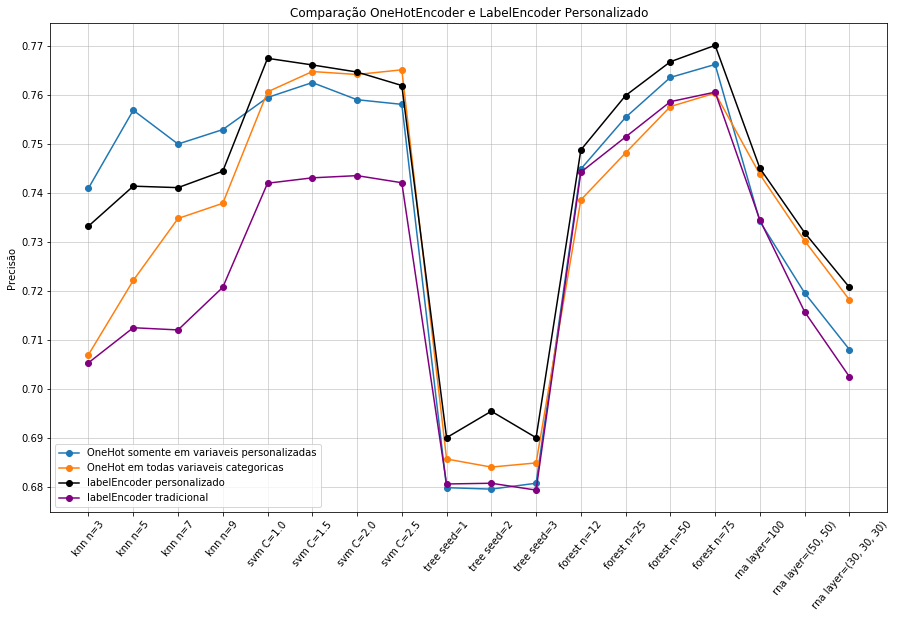

In [52]:
plt.figure(figsize=(15,9))
plt.plot(result_df2.columns, result_df2.iloc[0, :], 'o-', label='OneHot somente em variaveis personalizadas')
plt.plot(result_df2.columns, result_df3.iloc[0, :], 'o-', label='OneHot em todas variaveis categoricas')
plt.plot(result_df2.columns, result_df2.iloc[1, :], 'o-', label='labelEncoder personalizado', color='black')
plt.plot(result_df2.columns, result_df4.iloc[0, :], 'o-', label='labelEncoder tradicional', color='purple')
plt.legend()

plt.legend(loc=3)
plt.ylabel('Precisão')
plt.title('Comparação OneHotEncoder e LabelEncoder Personalizado')
plt.xticks(rotation=50)
plt.yticks(list(np.arange(0.68, 0.78, 0.01)))
plt.grid(axis='both', linewidth='0.5')

### Análise Gráfica
Ao comparar os resultados obtidos realizando o processo de *OneHotEncoder* apenas nas 4 variáveis ordinais selecionadas e em todas as variáveis que compõem o dataset e realizando somente o processo de *LabelEncoder 'personalizado'* nos 4 atributos selecionados *(cheque_especial, balanco_medio_credito, empregado, emprego)*, é possível perceber que a **variação das precisões** é pequena, em geral, ficando **abaixo de 1%**, embora, ainda assim, este último tenha apresentado resultados, em geral, um pouco melhores.

Além disso, vale ressaltar que o processo de ***OneHotEncoder*** implica em **aumento de dimensionalidade** dos dados, o que resulta em um maior esforço computacional. No caso desta base de dados, de **19 atributos previsores originais**, aplicando o processo às 4 variáveis em questão, passa-se a ter **33 atributos** previsores (aumento de mais de 50%), e se aplicado a todas as variáveis categóricas da base de dados, chega-se **59 atributos** previsores (3 vezes mais).

## Conclusão
O processo de *OneHotEncoder* mostrou que pode gerar resultados superiores ao processo de *labelEncoder 'tradicional'*, como esperado, e chegou relativamente bem próximo do processo de *labelEncoder 'personalizado'*, chegando a superá-lo no algoritmo KNN. No entanto, ele gera um aumento da dimensionalidade da base de dados.

Dessa forma, o processo proposto de *labelEncoder 'personalizado'* para variáveis categóricas ordinais, respeitando sua relação de ordenação, parece mostrar um potencial como forma interessante de melhora na precisão de algoritmos de machine learning para base de dados com esse tipo de variável.